# Ukraine war tweets

![alternatvie text](https://cdn.sanity.io/images/0vv8moc6/psychtimes/fa2efd3df4dd00eb8c1a6306a0a454a3564ad79e-5833x2143.jpg?fit=crop&auto=format)

## Introduction

TEXT

## About data

TEXT

## Data quality assessment

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import re

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\Asus\anaconda3\envs\notebook_myenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv(r'C:\Users\Asus\Desktop\DB\W\occ\western.csv', on_bad_lines='skip', delimiter='\t', encoding='latin1')

In [3]:
data.head(2)

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1.496640e+18,1.496640e+18,2022-02-24 02:01:32 GTB Standard Time,2/24/2022,2:01:32,300,2.388075e+09,liveuamap,Liveuamap,"{'type': 'Point', 'coordinates': [40.74881, -7...",...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,1.496640e+18,1.496640e+18,2022-02-24 02:02:33 GTB Standard Time,2/24/2022,2:02:33,300,2.388075e+09,liveuamap,Liveuamap,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [4]:
data.shape

(16727, 36)

In [5]:
data.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16727 entries, 0 to 16726
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               16727 non-null  float64
 1   conversation_id  16727 non-null  float64
 2   created_at       16727 non-null  object 
 3   date             16727 non-null  object 
 4   time             16727 non-null  object 
 5   timezone         16727 non-null  int64  
 6   user_id          16727 non-null  float64
 7   username         16727 non-null  object 
 8   name             16727 non-null  object 
 9   place            531 non-null    object 
 10  tweet            16727 non-null  object 
 11  language         16727 non-null  object 
 12  mentions         16727 non-null  object 
 13  urls             16727 non-null  object 
 14  photos           16727 non-null  object 
 15  replies_count    16727 non-null  int64  
 16  retweets_count   16727 non-null  int64  
 17  likes_count 

## Data transformation

### Deleting biased accounts from tweets list

In [7]:
data['username'].unique()

array(['liveuamap', 'deepnetanon', 'the_lookout_n', 'thestudyofwar',
       'cen4infores', 'konrad_muzyka', 'hannaliubakova', 'kylejglen',
       'uaweapons', 'kyivindependent', 'motolkohelp', 'shashj', 'ralee85',
       'citeam_en', 'oalexanderdk', 'kofmanmichael', 'osinttechnical',
       'nexta_tv', 'marqs__'], dtype=object)

In [8]:
new_list = ['liveuamap', 'thestudyofwar', 'hannaliubakova', 'kylejglen', 'uaweapons', 'ralee85', 'citeam_en',
            'kofmanmichael', 'osinttechnical', 'marqs__']

In [9]:
data = data[data['username'].isin(new_list)]

In [10]:
data['username'].unique()

array(['liveuamap', 'thestudyofwar', 'hannaliubakova', 'kylejglen',
       'uaweapons', 'ralee85', 'citeam_en', 'kofmanmichael',
       'osinttechnical', 'marqs__'], dtype=object)

In [11]:
data.shape

(8241, 36)

### Remove language != english

In [12]:
# delete language != en
print("Number of records  before filtering: ", len(data.index))
data = data.drop(data.index[data['language'] != 'en'])
print("Number of records after filtering: ", len(data.index))

Number of records  before filtering:  8241
Number of records after filtering:  6410


### Order by date

In [13]:
data.sort_values(by = 'created_at', ascending = True, inplace = True)

### Atribute selection

In [14]:
data = data[['id', 'created_at', 'date', 'time', 'username', 'name', 'tweet', 'language', 'mentions', 'photos', 
            'replies_count', 'retweets_count', 'likes_count', 'hashtags', 'link', 'retweet', 'video', 'reply_to']]

In [15]:
data.columns

Index(['id', 'created_at', 'date', 'time', 'username', 'name', 'tweet',
       'language', 'mentions', 'photos', 'replies_count', 'retweets_count',
       'likes_count', 'hashtags', 'link', 'retweet', 'video', 'reply_to'],
      dtype='object')

In [16]:
data.shape

(6410, 18)

### Views

The clearest ratio for measuring views based on likes is views = 4%, that's 4 Likes for every 100 views.

In [17]:
def categorise(row):  
    if row['likes_count'] > 0:
        return int(row['likes_count']/4*100)
    else:
        return 0
    
data['views_count'] = data.apply(lambda row: categorise(row), axis=1)

## Exploratory analysis & descriptive statistics

In [18]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,6410.0,1.508602e+18,7.796211e+15,1.496640e+18,1.501628e+18,1.507830e+18,1.515470e+18,1.523800e+18
replies_count,6410.0,4.252340e+01,1.067662e+02,0.000000e+00,6.000000e+00,1.800000e+01,4.200000e+01,5.055000e+03
retweets_count,6410.0,2.753871e+02,6.101928e+02,0.000000e+00,4.500000e+01,1.190000e+02,2.970000e+02,1.689900e+04
likes_count,6410.0,1.677469e+03,3.151683e+03,0.000000e+00,2.280000e+02,6.130000e+02,1.989500e+03,8.347200e+04
video,6410.0,6.120125e-01,4.873297e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
views_count,6410.0,4.193673e+04,7.879208e+04,0.000000e+00,5.700000e+03,1.532500e+04,4.973750e+04,2.086800e+06


In [19]:
print("###### likes mean ---->", round(np.mean(data['likes_count']), 2))
print("###### likes median ---->", int(np.median(data['likes_count'])))
print("###### likes standard deviation ---->", round(np.std(data['likes_count']), 2))
print()
print("###### retweets mean ---->", round(np.mean(data['retweets_count']), 2))
print("###### retweets median ---->", round(np.median(data['retweets_count']), 2))
print("###### retweets standarnd deviation ---->", round(np.std(data['retweets_count']), 2))
print()
print("###### replies mean ---->", round(np.mean(data['replies_count']), 2))
print("###### replies median ---->", round(np.median(data['replies_count']), 2))
print("###### replies standard deviation ---->", round(np.std(data['replies_count']), 2))
print()
print("###### views mean ---->", round(np.mean(data['views_count']), 2))
print("###### views median ---->", round(np.median(data['views_count']), 2))
print("###### views standard deviation ---->", round(np.std(data['views_count']), 2))

###### likes mean ----> 1677.47
###### likes median ----> 613
###### likes standard deviation ----> 3151.44

###### retweets mean ----> 275.39
###### retweets median ----> 119.0
###### retweets standarnd deviation ----> 610.15

###### replies mean ----> 42.52
###### replies median ----> 18.0
###### replies standard deviation ----> 106.76

###### views mean ----> 41936.73
###### views median ----> 15325.0
###### views standard deviation ----> 78785.93


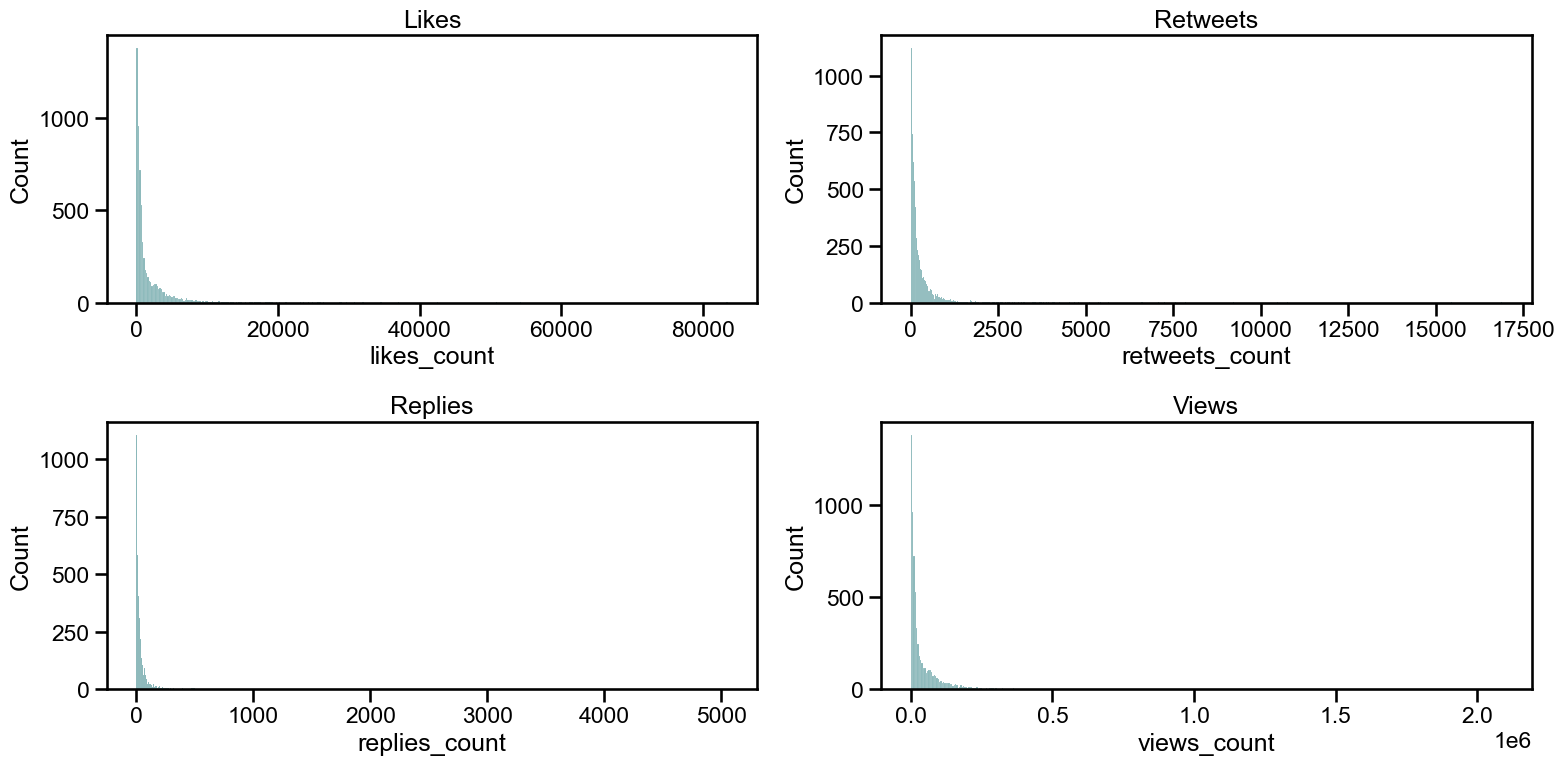

In [20]:
sns.set_context('talk',font_scale=1)
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(16,8))
sns.set_style("whitegrid")

a = sns.histplot(data['likes_count'], color = 'cadetblue', ax=axs[0,0])#, alpha = 0.5)
a.set_title('Likes')

b = sns.histplot(data['retweets_count'], color = 'cadetblue', ax=axs[0,1])#, alpha = 0.5)
b.set_title('Retweets')

c = sns.histplot(data['replies_count'], color = 'cadetblue', ax=axs[1,0])#, alpha = 0.5)
c.set_title('Replies')

d = sns.histplot(data['views_count'], color = 'cadetblue', ax=axs[1,1])#, alpha = 0.5)
d.set_title('Views')


plt.tight_layout()

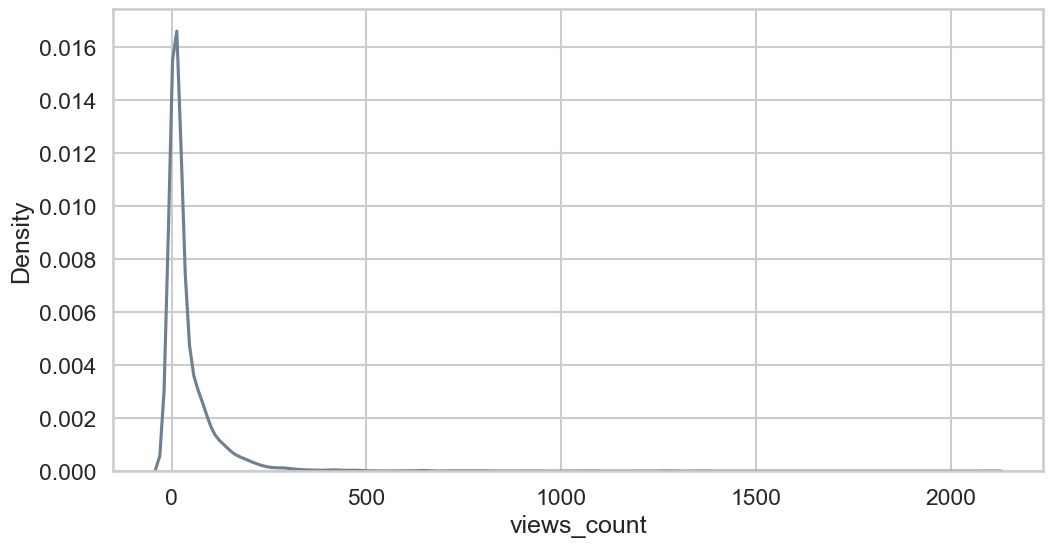

In [21]:
mycop = data.copy()
mycop['views_count'] = mycop['views_count'].apply(lambda x:x/1000) #normalization

fig = plt.figure(figsize=(12,6))
sns.kdeplot(mycop['views_count'], color = 'slategrey')
plt.show()

In [22]:
tweets_count = data.groupby('username').count().sort_values(by = 'tweet', ascending = False)

In [23]:
likes = data.groupby('username').sum().sort_values(by = 'likes_count', ascending = False)

In [24]:
retweets = data.groupby('username').sum().sort_values(by = 'retweets_count', ascending = False)

In [25]:
replies = data.groupby('username').sum().sort_values(by = 'replies_count', ascending = False)

In [26]:
views = data.groupby('username').sum().sort_values(by = 'views_count', ascending = False)

In [27]:
tweets_count

,id,created_at,date,time,name,tweet,language,mentions,photos,replies_count,retweets_count,likes_count,hashtags,link,retweet,video,reply_to,views_count
username,,,,,,,,,,,,,,,,,,
uaweapons,1337,1337,1337,1337,1337,1337,1337,1337,1337,1337,1337,1337,1337,1337,1337,1337,1337,1337
osinttechnical,1153,1153,1153,1153,1153,1153,1153,1153,1153,1153,1153,1153,1153,1153,1153,1153,1153,1153
ralee85,1016,1016,1016,1016,1016,1016,1016,1016,1016,1016,1016,1016,1016,1016,1016,1016,1016,1016
liveuamap,936,936,936,936,936,936,936,936,936,936,936,936,936,936,936,936,936,936
kylejglen,517,517,517,517,517,517,517,517,517,517,517,517,517,517,517,517,517,517
hannaliubakova,516,516,516,516,516,516,516,516,516,516,516,516,516,516,516,516,516,516
thestudyofwar,437,437,437,437,437,437,437,437,437,437,437,437,437,437,437,437,437,437
kofmanmichael,306,306,306,306,306,306,306,306,306,306,306,306,306,306,306,306,306,306
marqs__,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112


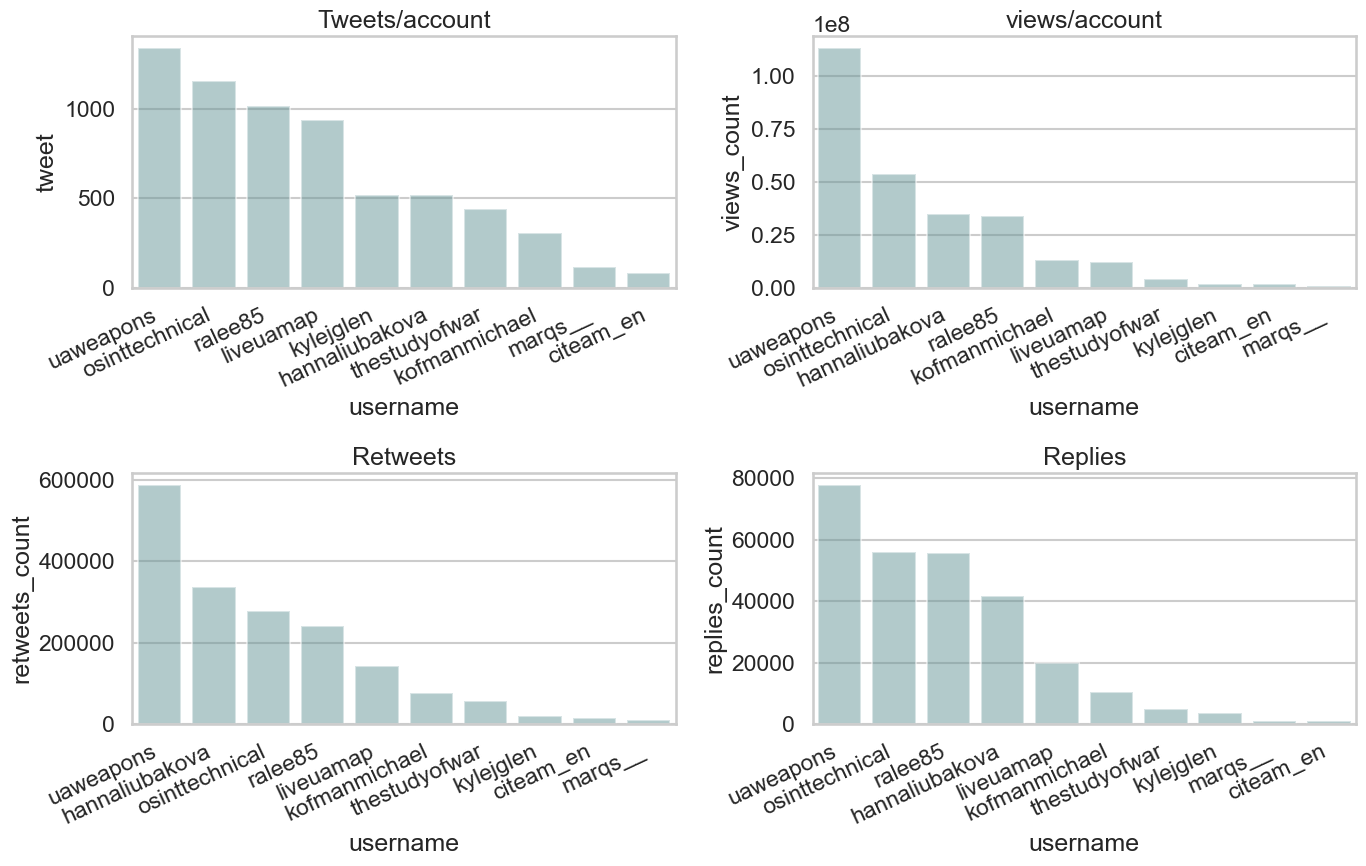

In [28]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(14,9))
sns.set_style("whitegrid")
a = sns.barplot(x = tweets_count.index, y = 'tweet', data = tweets_count, ax=axs[0,0], alpha = 0.5, color = 'cadetblue')
a.set_xticklabels(a.get_xticklabels(), rotation = 25, horizontalalignment = 'right')
a.set_title('Tweets/account')


b = sns.barplot(x = views.index, y = 'views_count', data = views, ax=axs[0,1], alpha = .5, color = 'cadetblue')
b.set_xticklabels(b.get_xticklabels(), rotation = 25, horizontalalignment = 'right')
b.set_title('views/account')

c = sns.barplot(x = retweets.index, y = 'retweets_count', data= retweets, ax=axs[1,0], alpha = 0.5, color = 'cadetblue')
c.set_xticklabels(c.get_xticklabels(), rotation = 25, horizontalalignment = 'right')
c.set_title('Retweets')

d = sns.barplot(x = replies.index, y = 'replies_count', data= replies, ax=axs[1,1], alpha = .5, color = 'cadetblue')
d.set_xticklabels(d.get_xticklabels(), rotation = 25, horizontalalignment = 'right')
d.set_title('Replies')


plt.tight_layout()

### Sorting

**Top 10 most liked tweets**

In [29]:
for tweet in data.sort_values(by = 'likes_count', ascending = False)['tweet'][:10]:
    print(tweet)
    print()

The head of the Ukrainian Railways Alexander Kamyshin confirmed that there is no railway connection between #Ukraine and #Belarus "thanks to Belarusian railway workers". They've indeed launched what they called "a railway war" with many acts of sabotage to stop Russian equipment  https://t.co/Tji0gkkdNP

In the Mykolaiv region,a 78-year-old man wanted to enroll in the territorial defense. Due to his age,he was refused to join. So he went to the checkpoint and threw a Molotov cocktail into the ????Grad multiple rocket launcher.The installation burned down. You won't break the spirit

#Russia More than 2000 people have been detained in Russia during anti-war protests. This is Moscow. This man is singing the state anthem of #Ukraine  https://t.co/4rndvpdK2v

In #Ukraine, Belarusians have created a separate battalion named after Kastus Kalinouski to defend Kyiv. According to them, more than 200 Belarusians have joined the territorial defense of Ukraine, another 300 intend to go to Ukraine.

**Top 10 most retweeted tweets**

In [30]:
for tweet in data.sort_values(by = 'retweets_count', ascending = False)['tweet'][:10]:
    print(tweet)
    print()

The head of the Ukrainian Railways Alexander Kamyshin confirmed that there is no railway connection between #Ukraine and #Belarus "thanks to Belarusian railway workers". They've indeed launched what they called "a railway war" with many acts of sabotage to stop Russian equipment  https://t.co/Tji0gkkdNP

#Russia More than 2000 people have been detained in Russia during anti-war protests. This is Moscow. This man is singing the state anthem of #Ukraine  https://t.co/4rndvpdK2v

In #Ukraine, Belarusians have created a separate battalion named after Kastus Kalinouski to defend Kyiv. According to them, more than 200 Belarusians have joined the territorial defense of Ukraine, another 300 intend to go to Ukraine. #Belarus  https://t.co/9PUxvcjXd9

Meanwhile Ukrainian drivers near Borodyanka of Kyiv region via @_catiko  https://t.co/WLRSLdhH5v

Every day, Russian jet fighters take off from Belarusian airfields and fly in direction of #Ukraine. Every missile attack on Kyiv is most probably lau

**Top 10 tweets with most replies**

In [31]:
for tweet in data.sort_values(by = 'replies_count', ascending = False)['tweet'][:10]:
    print(tweet)
    print()

An enormous car parade of cars with mostly Russian flags in Berlin, #Germany, today. Reportedly, the parade in support of Russia gathered 5000 cars.  They can't complain about the media blackout in Germany. They have access to information and can see what Russians did in Bucha.  https://t.co/20Oco5p3RB

Another video of Rosgvardia Chechen troops firing wildly at a building in Mariupol.   https://t.co/8KP5k9vBeA  https://t.co/Px3Cyzyesn

Colonel Alexander Bespalov, the commander of the 59th Guards Tank Regiment (part of the 144th Guards Motorized Rifle Division), was killed in Ukraine.  https://t.co/eKtTippOWr  https://t.co/UgcCe7ZTKQ  https://t.co/Dtfm3Mglxn

First major surrender of Ukrainian forces in Mariupol, reportedly 267 marines.  https://t.co/w5c5U3j4zG

"Putin is being misinformed by his advisers about how badly the Russian military is performing and how the Russian economy is being crippled by sanctions because his senior advisers are too afraid to tell him the truth," a US o

### Grouping by date

In [32]:
bydate = data.groupby("date").count()
data.groupby("date").count()

,id,created_at,time,username,name,tweet,language,mentions,photos,replies_count,retweets_count,likes_count,hashtags,link,retweet,video,reply_to,views_count
date,,,,,,,,,,,,,,,,,,
2/24/2022,136,136,136,136,136,136,136,136,136,136,136,136,136,136,136,136,136,136
2/25/2022,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113
2/26/2022,162,162,162,162,162,162,162,162,162,162,162,162,162,162,162,162,162,162
2/27/2022,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128
2/28/2022,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5/5/2022,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39
5/6/2022,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28
5/7/2022,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49


### Tweets/day

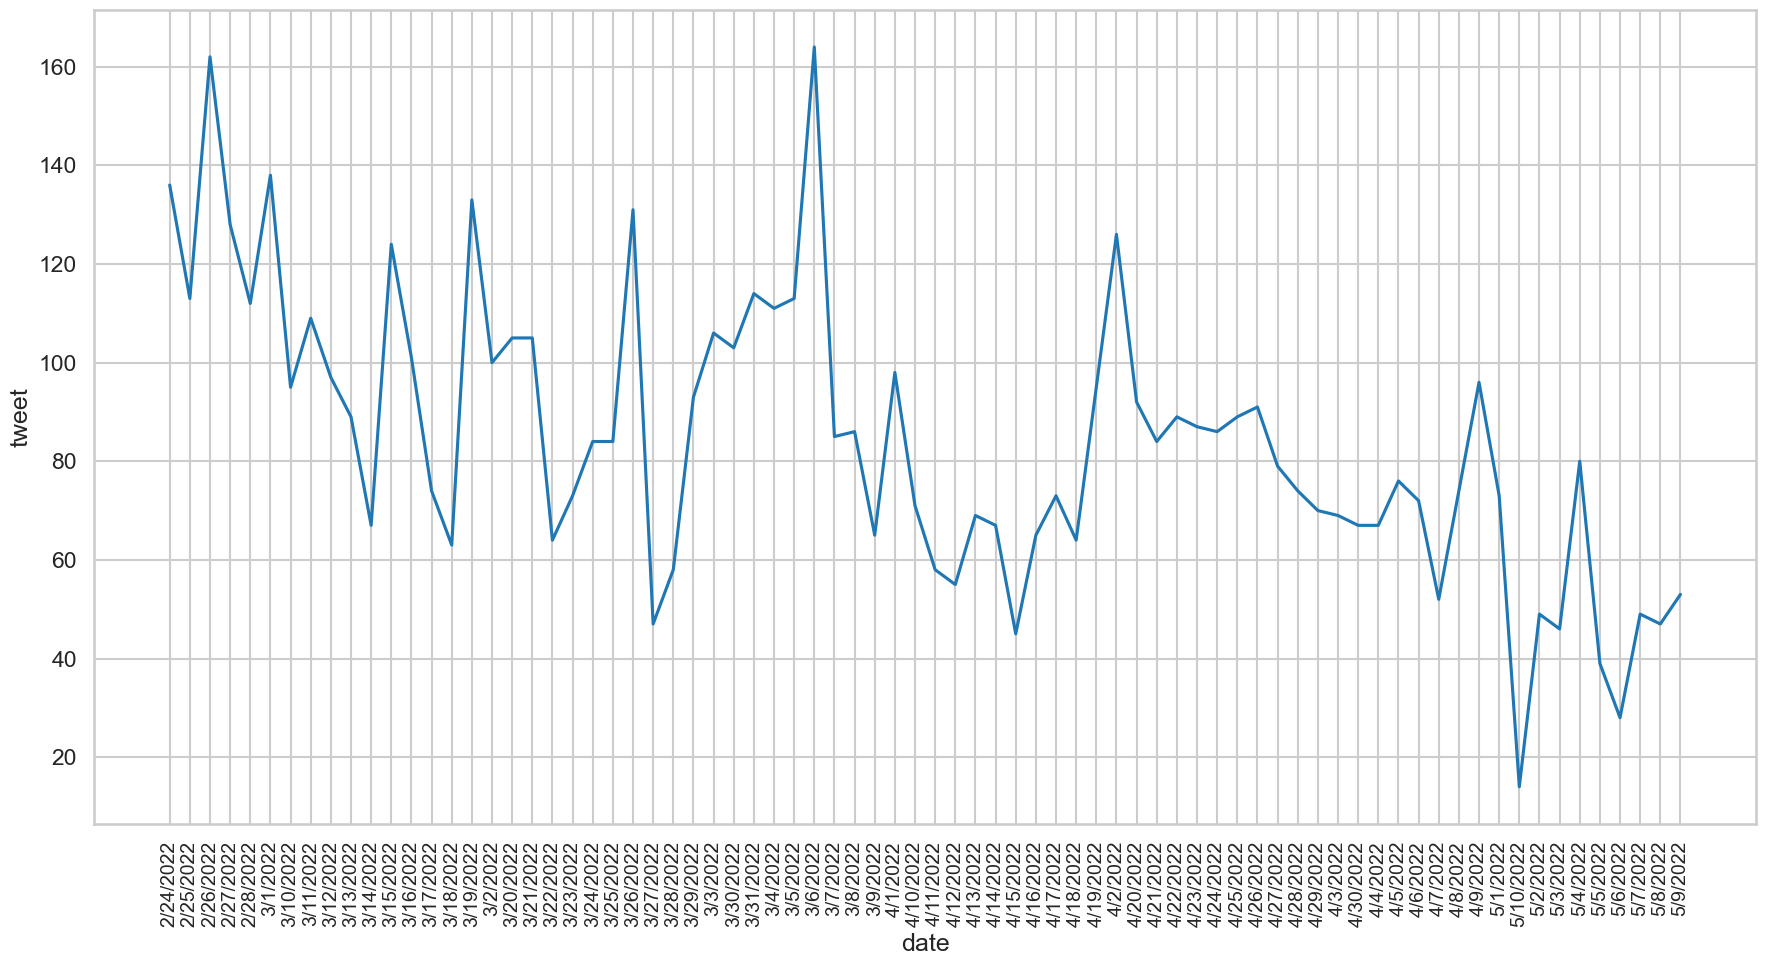

In [33]:
fig = plt.figure(figsize=(18,10))

f = sns.lineplot(x = bydate.index, y ='tweet', data = bydate)
f.tick_params(axis='x', rotation=90, labelsize = 14)
plt.tight_layout()
plt.show()

## Views/day

In [34]:
bydate2 = data.groupby("date").sum()

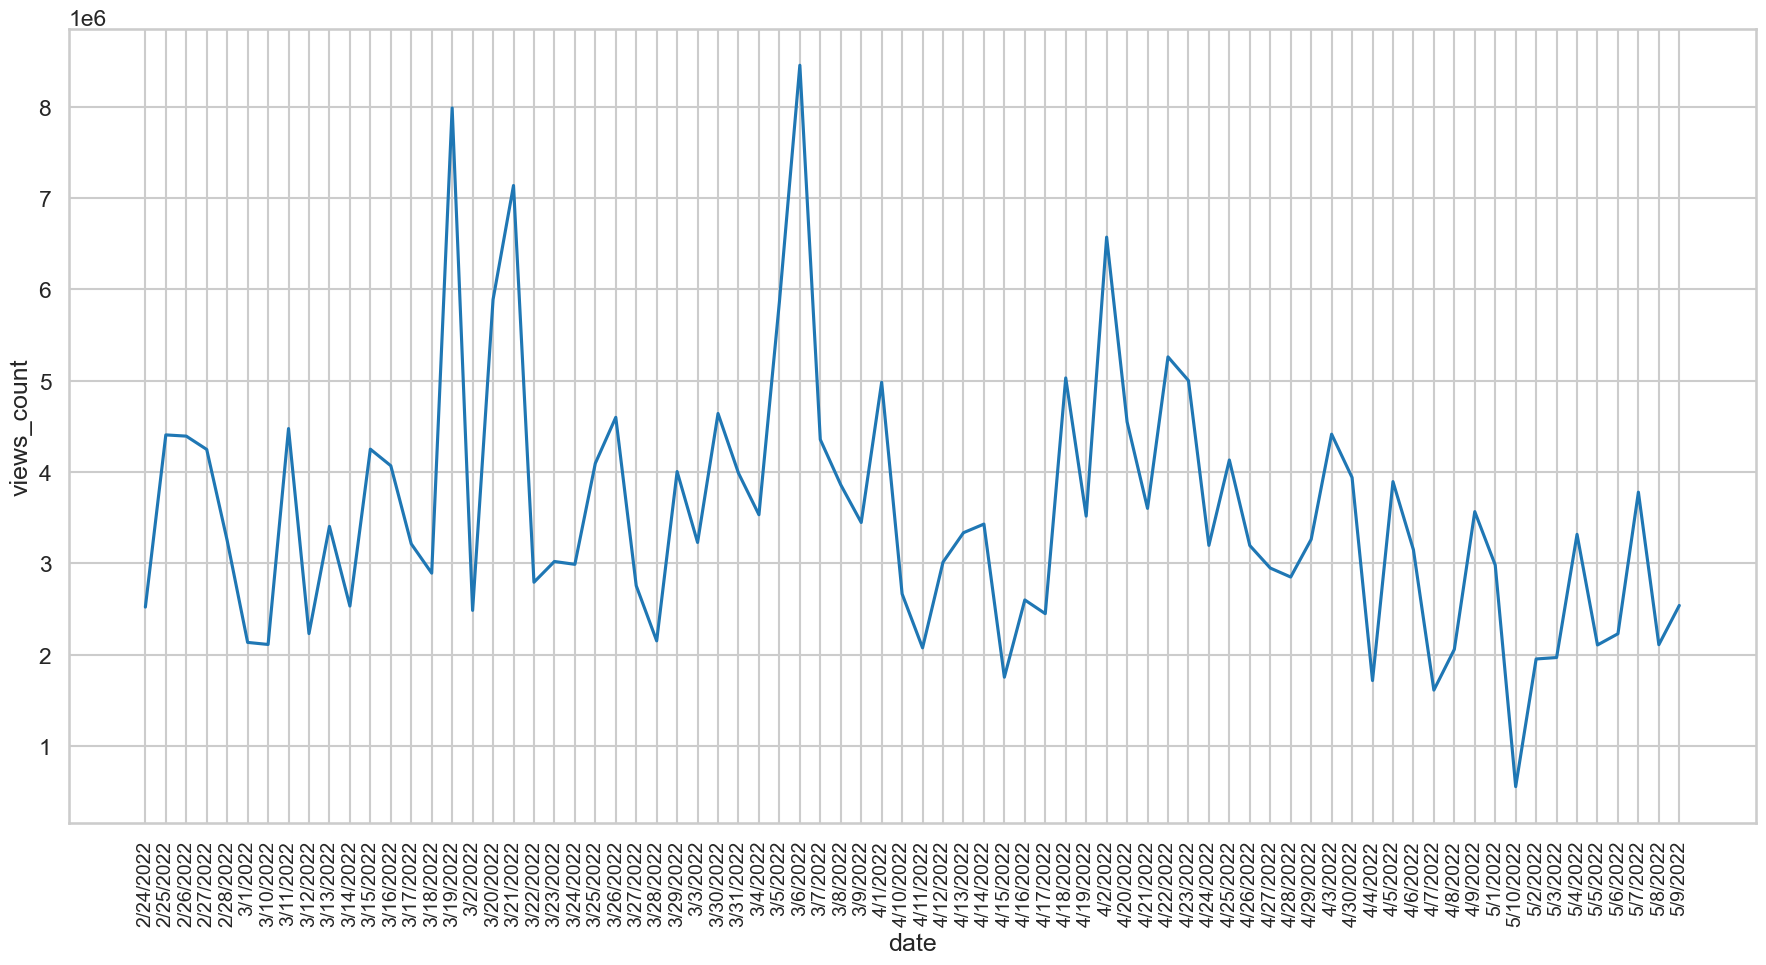

In [35]:
fig = plt.figure(figsize=(18,10))

f = sns.lineplot(x = bydate2.index, y ='views_count', data = bydate2)
f.tick_params(axis='x', rotation=90, labelsize = 14)
plt.tight_layout()
plt.show()

## Sentiment analysis

### Tweets pre processing

* remove links
* remove @s and #s 
* replace .,!? with "end of sentence" marks to "help" the model

In [36]:
corpus_tweet = []
for tweet in data['tweet']:
    corpus_tweet.append(tweet)

In [37]:
corpus_tweet

['UN Security Council to hold emergency session on Ukraine Wednesday night, diplomats say  https://t.co/vBiRxoPa8R via @AFP #Ukraine',
 'At 4:30 Kyiv time. Most urgent after years  https://t.co/FFk1CEuqH9',
 'Rare meeting of UNSC the same day(NY time) when requested  https://t.co/FFk1CEuqH9',
 'Two Turkish Air Force Airbus A400M entered Ukrainian airspace. Looks like first one heading to Kyiv  https://t.co/UDZxp0B6LW via @MarQs__ #Ukraine  https://t.co/gHB1D46L7l',
 'Another cyber attack targeting the website of Security Service of Ukraine',
 'U.S.. Secretary of state Blinken believes Russia will invade Ukraine before the night is over - NBC news  https://t.co/PiLUMlO1kh via @phildstewart #Ukraine',
 'Clashes audible this night in Mariupol  https://t.co/cAoxQnRUSK  https://t.co/c3WsF4sKML via @herooftheday10 #Ukraine',
 'Blinken: We are doubling our security, diplomatic and humanitarian assistance to Ukraine  https://t.co/HsgAZCoa9K via @AJABreaking #Ukraine',
 'The B-52?s landed in th

In [38]:
def tweet_process(tweet):
    tweet = re.sub(r"http\S+", "", tweet)
    tweet = tweet.replace("@", "")
    tweet = tweet.replace("#", "")
    return(tweet)

In [39]:
korpus = []
for tweet in corpus_tweet:
    korpus.append(tweet_process(tweet))

In [40]:
korpus

['UN Security Council to hold emergency session on Ukraine Wednesday night, diplomats say   via AFP Ukraine',
 'At 4:30 Kyiv time. Most urgent after years  ',
 'Rare meeting of UNSC the same day(NY time) when requested  ',
 'Two Turkish Air Force Airbus A400M entered Ukrainian airspace. Looks like first one heading to Kyiv   via MarQs__ Ukraine  ',
 'Another cyber attack targeting the website of Security Service of Ukraine',
 'U.S.. Secretary of state Blinken believes Russia will invade Ukraine before the night is over - NBC news   via phildstewart Ukraine',
 'Clashes audible this night in Mariupol     via herooftheday10 Ukraine',
 'Blinken: We are doubling our security, diplomatic and humanitarian assistance to Ukraine   via AJABreaking Ukraine',
 'The B-52?s landed in the Czech Republic Feb. 21, practicing quick-turn sortie generation and flying maneuvers alongside Czech fighter aircraft   via defense_news Ukraine',
 'Israeli civilian aircraft that was flying over western Ukraine has

In [42]:
import nltk
from nltk.corpus import twitter_samples
import numpy as np

In [43]:
nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


True

In [44]:
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

In [45]:
print(len(all_positive_tweets))
print(len(all_negative_tweets))
print(type(all_positive_tweets))
print(type(all_negative_tweets[1]))

5000
5000
<class 'list'>
<class 'str'>


In [46]:
print(all_positive_tweets[0])
print(all_negative_tweets[0])

#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
hopeless for tmr :(


In [50]:
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg
test_x = test_pos + test_neg

train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))
test_y = np.append(np.ones(len(test_pos)), np.zeros(len(test_neg)))

In [51]:
def create_frequency(tweets, ys):
    
    freq_d = {}
    
    for tweet, y in zip(tweets, ys):
        for word in tweet_process(tweet):
            
            pair = (word, y)
            
            if pair in freq_d:
                freq_d[pair] += 1
            else:
                freq_d[pair] = freq_d.get(pair, 1) 
    
    return freq_d

In [52]:
# testing function

tweets = ['i am happy', 'i am tricked', 'i am sad', 'i am tired', 'i am tired']
ys = [1, 0, 0, 0, 0]

freq_d = create_frequency(tweets, ys)
print(freq_d)

{('i', 1): 1, (' ', 1): 2, ('a', 1): 2, ('m', 1): 1, ('h', 1): 1, ('p', 1): 2, ('y', 1): 1, ('i', 0): 7, (' ', 0): 8, ('a', 0): 5, ('m', 0): 4, ('t', 0): 3, ('r', 0): 3, ('c', 0): 1, ('k', 0): 1, ('e', 0): 3, ('d', 0): 4, ('s', 0): 1}


In [53]:
# build the freqs dictionary

freqs = create_frequency(train_x, train_y)

In [54]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of tweets
        train_y: a list of labels correponding to the tweets (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    
    loglikelihood = {}
    logprior = 0
    
    # calculate the number of unique words in vocab
    unique_words = set([pair[0] for pair in freqs.keys()])
    V = len(unique_words)
    
    # calculate N_pos and N_neg
    N_pos = N_neg = 0
    for pair in freqs.keys():
        
        # TODO: get N_pos and N_get
        if pair[1] > 0:
            N_pos += freqs[(pair)]
            
        else:
            N_neg += freqs[(pair)]
            
    # TODO: calculate the number of documents (tweets)
    D = train_y.shape[0]
    
    # TODO: calculate D_pos, the number of positive documents (tweets)
    D_pos = sum(train_y)
    
    # TODO: calculate D_neg, the number of negative documents (tweets)
    D_neg = D - sum(train_y)
    
    # TODO: calculate logprior
    logprior = np.log(D_pos) - np.log(D_neg)
    
    # for each unqiue word
    for word in unique_words:
        
        # get the positive and negative frequency of the word
        freq_pos = freqs.get((word, 1), 0)
        freq_neg = freqs.get((word, 0), 0)
        
        # calculate the probability that word is positive, and negative
        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)
        
        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)
        
    return logprior, loglikelihood

In [55]:
logprior, loglikelihood = train_naive_bayes(freqs, train_x, train_y)
print(logprior)
print(len(loglikelihood))

0.0
312


In [56]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def naive_bayes_predict(tweet, logprior, loglikelihood):
    '''
    Input:
        tweet: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Output:
        p: the sum of all the logliklihoods of each word in the tweet (if found in the dictionary) + logprior (a number)

    '''

    # TODO: process the tweet to get a list of words
    word_l = tweet_process(tweet)

    # TODO: initialize probability to zero
    p = 0

    # TODO: add the logprior
    p += logprior

    for word in word_l:

        # TODO: get log likelihood of each keyword
        if  word in loglikelihood:
            p += loglikelihood[word]

    return p

In [57]:
# testing my function
for tweet in ['I am happy', 'I am bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great', 'bad bad bad bad']:
    # print( '%s -> %f' % (tweet, naive_bayes_predict(tweet, logprior, loglikelihood)))
    p = naive_bayes_predict(tweet, logprior, loglikelihood)
#     print(f'{tweet} -> {p:.2f} ({p_category})')
    print(f'{tweet} -> {p:.2f}')

I am happy -> -0.32
I am bad -> -0.74
this movie should have been great. -> 0.29
great -> 0.15
great great -> 0.24
great great great -> 0.34
great great great great -> 0.43
bad bad bad bad -> -0.55


In [58]:
data['tweet'] = data['tweet'].astype('string') 
my_list = data['tweet'].tolist()

In [59]:
p_list = []
for tweet in my_list:
    p = naive_bayes_predict(tweet, logprior, loglikelihood)
    p_list.append(p)
    
df = pd.Series(p_list)
ndf = df.to_frame(name = 'p')

In [60]:
data['sentiment'] = p_list

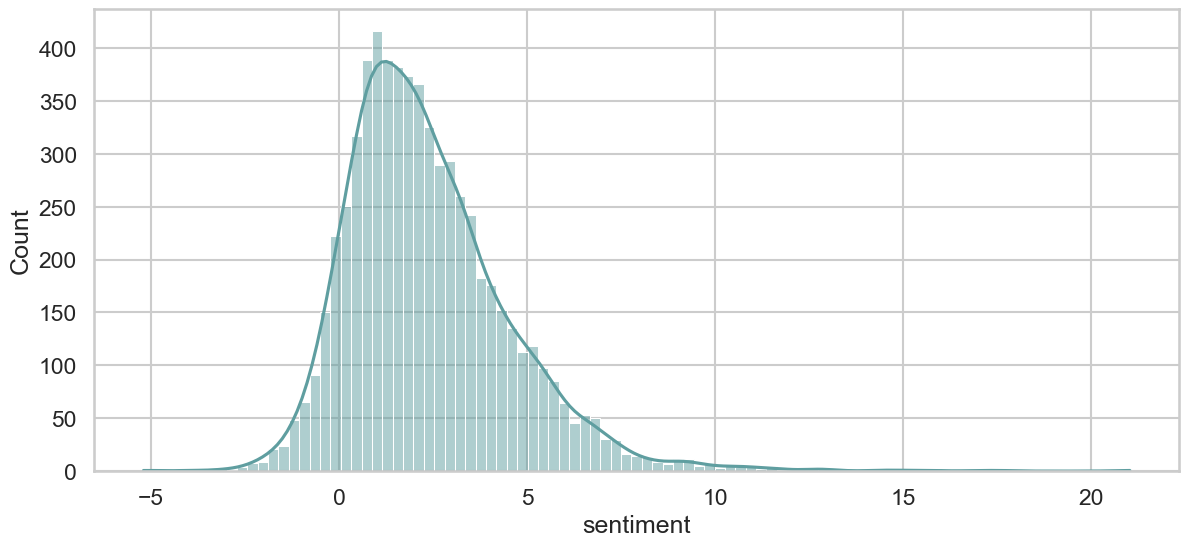

In [79]:
fig = plt.figure(figsize=(14,6))
sns.histplot(data['sentiment'], kde = True, color = 'cadetblue')
plt.show()

In [80]:
data['sentiment'].describe().transpose()

count    6410.000000
mean        2.358769
std         2.186438
min        -5.202749
25%         0.870897
50%         1.999609
75%         3.457707
max        21.027809
Name: sentiment, dtype: float64

## Daily summarization

In [97]:
date  = data[data['date'] == '3/1/2022']

In [99]:
text = ''
for tweet in date['tweet']:
    text += tweet

### Pre processing

In [100]:
text = re.sub(r"http\S+", "", text)
text = text.replace("@", "")
text = text.replace("#", "")
text = text.replace(".", ".<eos>")
text = text.replace("!", ".<eos>")
text = text.replace("?", ".<eos>")

sentences = text.split("<eos>")

new_sentences = []
for sen in sentences:
    if len(sen) < 5:
        continue
    else:
        new_sentences.append(re.sub(' +', ' ', sen)) # remove extra spaces

In [101]:
new_sentences

["Rafim If they have been stored in a stable condition it wouldn't be an issue to use them.",
 'We are down(almost completely), soon will be backUkraine: Apparently, one more abandoned Russian BTR-82A was stolen by Ukrainian civilians.',
 ' The Russian military is reorganizing its efforts in an attempt to remedy poor planning and execution based on erroneous assumptions about Ukrainians\x92 will and ability to resist.',
 ' Click here to read the report and see our map: In the vicinity of Kharkiv another Russian convoy was destroyed, this time approximately 12 Supply trucks.',
 ' pics have arrived of the capture by the Armed Forces of Ukraine from the Russians; including what appears to be 280mm rockets (For the BM-30 Smerch and similar systems), 1986 dated PG-7L &amp; more.',
 ' The loss of the rockets could effect Russian efforts to to hit the city.',
 ' Ukraine Conflict Update: The next major phase of Russian offensive operations will likely begin within the next 24 hours and play ou

In [102]:
from transformers import pipeline

summarizer = pipeline("summarization")

max_chunk = 500
current_chunk = 0 
chunks = []
for sentence in new_sentences:
    if len(chunks) == current_chunk + 1: 
        if len(chunks[current_chunk]) + len(sentence.split(' ')) <= max_chunk:
            chunks[current_chunk].extend(sentence.split(' '))
        else:
            current_chunk += 1
            chunks.append(sentence.split(' '))
    else:
        print(current_chunk)
        chunks.append(sentence.split(' '))

for chunk_id in range(len(chunks)):
    chunks[chunk_id] = ' '.join(chunks[chunk_id])

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


0


In [103]:
result = summarizer(chunks, max_length=120, min_length=30, do_sample=False)

In [104]:
result

[{'summary_text': " Russian military reorganizing its efforts in an attempt to remedy poor planning and execution based on erroneous assumptions about Ukrainians' will and ability to resist . Another Russian convoy was destroyed in the vicinity of Kharkiv another Russian convoy destroyed, this time approximately 12 Supply trucks . The loss of the rockets could effect Russian efforts to to hit the city ."},
 {'summary_text': ' More and more information is emerging on the poor food supply and living conditions of the Russian soldiers . Prisoner testimonies and media reports suggest that prior to the invasion the troops at the border were living in trenches, sleeping in their vehicles or even in the streets .'},
 {'summary_text': " Last day to apply for the 2022 HertogFDN War Studies Program . Morale is low, nothing was organized, soldiers don't want to fight &amp; readily abandon kit . Russian troops themselves had no idea they were going to launch this op and were completely unprepared 

In [105]:
Summary = ''
for i in range(len(result)):
    Summary += result[i]['summary_text']
    
Summary

" Russian military reorganizing its efforts in an attempt to remedy poor planning and execution based on erroneous assumptions about Ukrainians' will and ability to resist . Another Russian convoy was destroyed in the vicinity of Kharkiv another Russian convoy destroyed, this time approximately 12 Supply trucks . The loss of the rockets could effect Russian efforts to to hit the city . More and more information is emerging on the poor food supply and living conditions of the Russian soldiers . Prisoner testimonies and media reports suggest that prior to the invasion the troops at the border were living in trenches, sleeping in their vehicles or even in the streets . Last day to apply for the 2022 HertogFDN War Studies Program . Morale is low, nothing was organized, soldiers don't want to fight &amp; readily abandon kit . Russian troops themselves had no idea they were going to launch this op and were completely unprepared for it . Russia has committed more than 80% of its pre-staged co